In [1]:
import tensorflow as tf
import numpy as np

# Data

In [2]:
dataset_name = 'Data/AmazonFashion6ImgPartitioned.npy'

dataset = np.load(dataset_name, allow_pickle=True, encoding='latin1')

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

## Transform StringIO format to BytesIO 

In [71]:
from PIL import Image
import requests
from io import BytesIO

for i in range(10):
    response = requests.get(Item[i]['imUrl'])
    Item[i]['imgs'] = BytesIO(response.content)

In [74]:
Item[7]

{'asin': 'B007IL5PW2',
 'c': array([False, False, False, False, False,  True]),
 'title': "SoftSpots Posie Women's Flat",
 'imUrl': 'http://ecx.images-amazon.com/images/I/41hlGOB%2BI8L._SX395_.jpg',
 'related': {'also_bought': ['B00DJ3E5LU',
   'B008BQS296',
   'B008VWG36Y',
   'B002GWUINO',
   'B002RPL8BQ',
   'B006HH2W5Q',
   'B00518GZ1O',
   'B0008KM58W',
   'B00008LUS5',
   'B008DRPDTA',
   'B008A2ADBQ',
   'B001QV8TLY',
   'B007CL73KA',
   'B004LY127Q',
   'B0079LULVG',
   'B008A2AD8E',
   'B00BRC5L9K',
   'B004LKVE0U',
   'B00ARR28GU',
   'B006R4IBJK',
   'B00E3QK06Q',
   'B00C655ZQ6',
   'B00EFXHP4W',
   'B001F0QNBY',
   'B008RW72VS',
   'B002CMLD5U',
   'B006H4HHYA',
   'B000N0EM7O',
   'B00AQWW63Q',
   'B000C7I4C2',
   'B008F5HPC8',
   'B004WI1YRE',
   'B00B9AGZ9K',
   'B00B5BBNOA',
   'B009XPQA7U',
   'B00DG7AXHO',
   'B008CC1I2C',
   'B007IGQ7F6',
   'B009CW51V0',
   'B007C1CYEA',
   'B008MHVRPA'],
  'also_viewed': ['B00DJ3E5LU',
   'B008BQS296',
   'B008VWG36Y',
   'B008A2A

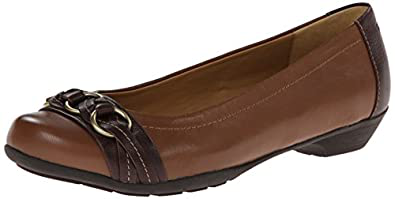

In [73]:
Image.open(Item[7]['imgs'])

# Create Model

## Wrappers

In [3]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

## Weights and Biases

In [4]:
nolf = 100 # Size of visual feature vector = final fully connected layer of CNN

In [5]:
weights = {
    'wc1': [11, 11, 3, 64],
    'wc2': [5, 5, 64, 256],
    'wc3': [3, 3, 256, 256],
    'wc4': [3, 3, 256, 256],
    'wc5': [3, 3, 256, 256],    
    'wd1': [7*7*256, 4096],
    'wd2': [4096, 4096],
    'wd3': [4096, nolf],
}

biases = {
    'bc1': [64],
    'bc2': [256],
    'bc3': [256],
    'bc4': [256],
    'bc5': [256],
    'bd1': [4096],
    'bd2': [4096],
    'bd3': [nolf],
}

In [6]:
def Weights(name):
    return tf.Variable(name,dtype=tf.float32,shape=weights[name],initializer=tf.compat.v1.initializers.glorot_normal())

def Biases(name):
    return tf.get_variable(name,dtype=tf.float32,initializer=tf.zeros(biases[name]))

## CNN

In [7]:
def CNN(x,dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 224, 224, 3])


    conv1 = conv2d(x, Weights('wc1'), Biases('bc1'), strides=4)
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, Weights('wc2'), Biases('bc2'))
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, k=2)
    
    conv3 = conv2d(conv2, Weights('wc3'), Biases('bc3'))
    conv3 = tf.nn.relu(conv3)
    
    conv4 = conv2d(conv3, Weights('wc4'), Biases('bc4'))
    conv4 = tf.nn.relu(conv4)
    
    conv5 = conv2d(conv4, Weights('wc5'), Biases('bc5'))
    conv5 = tf.nn.relu(conv5)
    conv5 = maxpool2d(conv5, k=2)

    fc1 = tf.reshape(conv5, [-1,weights['wd1'][0]])
    fc1 = tf.add(tf.matmul(fc1, Weights('wd1')), Biases('bd1'))
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    fc2 = tf.add(tf.matmul(fc1, Weights('wd2')), Biases('bd2'))
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = tf.add(tf.matmul(fc2, Weights('wd3')), Biases('bd3'))
    
    return fc3

In [8]:
print(tf.config.experimental.list_physical_devices("GPU"), 'GPU not available')

[] GPU not available


In [10]:
class CNN_F_feature_vect(tf.keras.Model):
    """Represents one of the siamese nets
    Output is a feature vector describing the input image"""
    
    def __init__(self):
#         self.conv1 = tf.keras.layers.Conv2D(strides=4, activation='relu')
#         self.maxP1 = tf.keras.layers.MaxPool2D(strides=4, activation='relu')
        # REWRITE TO KERAS?
        self.conv1 = tf.nn.relu(conv2d(x, weights['wc1'], biases['bc1'], strides=4))
        self.conv1_pool = maxpool2d(conv1, k=2)
        
        self.conv2 = tf.nn.relu(conv2d(conv1, weights['wc2'], biases['bc2']))
        self.conv2_pool = maxpool2d(conv2, k=2)

        self.conv3 = tf.nn.relu(conv2d(conv2, weights['wc3'], biases['bc3']))

        self.conv4 = tf.nn.relu(conv2d(conv3, weights['wc4'], biases['bc4']))

        self.conv5 = tf.nn.relu(conv2d(conv4, weights['wc5'], biases['bc5']))
        self.conv5_pool = maxpool2d(conv5, k=2)
        
        self.fc1_reshape = tf.reshape(conv5, [-1,weights['wd1'][0]])
        self.fc1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])), dropout)

        self.fc2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])), dropout)
        
    def __call__(self, x, dropout):
        #Convolutional layers
        x = self.conv1(x)
        x = self.conv1_pool(x)
        x = self.conv2(x)
        x = self.conv2_pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv5_pool(x)
        
        #Dense (fully connected layers)
        x = self.fc1_reshape(x)
        x = self.fc1(x, dropout)
        x = self.fc2(x, dropout)
        return x

In [ ]:
class CNN_F_feature_vect(tf.keras.Model):
    """Represents one of the siamese nets
    Output is a feature vector describing the input image"""
    
    def __init__(self):
#         self.conv1 = tf.keras.layers.Conv2D(strides=4, activation='relu')
#         self.maxP1 = tf.keras.layers.MaxPool2D(strides=4, activation='relu')
        # REWRITE TO KERAS?
        self.conv1 = tf.keras.layers.Conv2D(
            tf.nn.relu(conv2d(x, weights['wc1'], biases['bc1'], strides=4))
        self.conv1_pool = maxpool2d(conv1, k=2)
        
        self.conv2 = tf.nn.relu(conv2d(conv1, weights['wc2'], biases['bc2']))
        self.conv2_pool = maxpool2d(conv2, k=2)

        self.conv3 = tf.nn.relu(conv2d(conv2, weights['wc3'], biases['bc3']))

        self.conv4 = tf.nn.relu(conv2d(conv3, weights['wc4'], biases['bc4']))

        self.conv5 = tf.nn.relu(conv2d(conv4, weights['wc5'], biases['bc5']))
        self.conv5_pool = maxpool2d(conv5, k=2)
        
        self.fc1_reshape = tf.reshape(conv5, [-1,weights['wd1'][0]])
        self.fc1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])), dropout)

        self.fc2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])), dropout)
        
    def __call__(self, x, dropout):
        #Convolutional layers
        x = self.conv1(x)
        x = self.conv1_pool(x)
        x = self.conv2(x)
        x = self.conv2_pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv5_pool(x)
        
        #Dense (fully connected layers)
        x = self.fc1_reshape(x)
        x = self.fc1(x, dropout)
        x = self.fc2(x, dropout)
        return x

In [11]:
model = CNN_F_feature_vect()

NameError: name 'x' is not defined